# Build an agent that uses LangGraph and custom tools
LangGraph is a powerful framework for constructing intelligent agents that leverage large language models (LLMs) to perform complex tasks. Built on top of the popular LangChain library, LangGraph provides a high-level interface for defining agent behavior using a graph-based approach.

In this notebook, we'll walk through the process of building an intelligent agent using LangGraph. We'll cover the key concepts and provide code samples.

## Setting Up
Uncomment to install the package

In [181]:
# pip install -U langgraph langchain-anthropic

Uncomment if API key is not added yet

In [182]:
# import getpass
# import os

# os.environ["ANTHROPIC_API_KEY"] = getpass.getpass()

# Build a Basic Agent

In [183]:
import os
import uuid
from typing import Dict, List, Literal

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

from langchain.prompts import ChatPromptTemplate
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool

In [184]:
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620", api_key=os.environ["ANTHROPIC_API_KEY"], verbose = True)

graph_builder = StateGraph(MessagesState)

## Add Tools

In [185]:
# use mock recent interactions. Ideally this would be a call to a CRM API
recent_interactions = [
    {"date": "2024-08-01", "note": "Talked about our cool new product. They are very interested in QuickShipper, but they want to see a demo and hear about pricing details."},
    {"date": "2024-07-28", "note": "Only got to chat for a few minutes. They told me their budgets had been cut in half."},
    {"date": "2024-07-20", "note": "Had our monthly touch base. We promised to follow up with an overview of our upcoming QuickShipper service."},
    {"date": "2024-07-10", "note": "Followed up on reliability concerns."},
    {"date": "2024-06-25", "note": "Discussed their concerns about our current shipping service. They said it is not very reliable."},
]

@tool
def get_recent_interactions() -> List[Dict[str, str]]:
    """
    Retrieves the most recent interactions with a client.
    
    Returns:
    list: A list of dictionaries containing date and note for each interaction.
    """
    return recent_interactions

tools = []
tools.append(get_recent_interactions)

tool_node = ToolNode(tools=tools)
graph_builder.add_node(tool_node)

## Define the nodes

In [186]:
CRM_ASSISTANT_PROMPT = ("You are a customer relationship management (CRM) assistant designed to support a salesperson in "
    "effectively managing their customer relationships. You have access to comprehensive customer data, "
    "including company overviews, interaction history (e.g., meeting times, notes on discussions), "
    "and customer preferences. Your primary task is to help the salesperson plan their interactions and "
    "tailor their approach to maximize customer satisfaction and drive sales."
)

chat_prompt_template = ChatPromptTemplate.from_messages([
    ("system", CRM_ASSISTANT_PROMPT),
    ("human", "{input}")
])

# Tell the LLM to use the tool
llm_with_tools = chat_prompt_template | llm.bind_tools(tools)

def crm_assistant(state: MessagesState):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

graph_builder.add_node("crm_assistant", crm_assistant)

In [187]:
graph_builder.add_edge(START, "crm_assistant")
graph_builder.add_conditional_edges("crm_assistant", tools_condition)
graph_builder.add_edge("crm_assistant", "tools")

checkpointer = MemorySaver()

graph = graph_builder.compile(checkpointer=checkpointer)

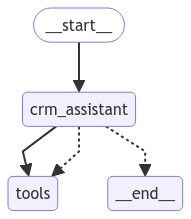

In [188]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## Running the Agent

In [189]:
user_input_list = ["Can you help me? I have a question.",
                   "Given our recent interactions, what are their top concerns and interests?",
                   "Can you summarize it for me?",
                   "quit"]

# To remember the context of conversation between session, use same thread_id
THREAD_ID = uuid.uuid4()

for user_input_item in  user_input_list:
    printed_user_input = "User: " + user_input_item
    print(printed_user_input)
    if user_input_item.lower() in ["quit", "exit", "q"]:
        print("Assistant: Goodbye!")
        break
    initial_state = {
        "messages": [{"role": "user", "content": user_input_item}]
    }
    final_state = graph.invoke(initial_state, config={"configurable": {"thread_id": THREAD_ID}})
    assistant_response = final_state["messages"][-1].content
    print("Assistant:", assistant_response)

User: Can you help me? I have a question.
Assistant: Of course! I'd be happy to help you with your question. As a CRM assistant, I'm here to support you with managing customer relationships, planning interactions, and providing insights based on customer data. Could you please provide more details about your question? Is it related to a specific customer, interaction history, or any particular aspect of customer relationship management?
User: Given our recent interactions, what are their top concerns and interests?
Assistant: [{"date": "2024-08-01", "note": "Talked about our cool new product. They are very interested in QuickShipper, but they want to see a demo and hear about pricing details."}, {"date": "2024-07-28", "note": "Only got to chat for a few minutes. They told me their budgets had been cut in half."}, {"date": "2024-07-20", "note": "Had our monthly touch base. We promised to follow up with an overview of our upcoming QuickShipper service."}, {"date": "2024-07-10", "note": "